Here we join the harmonised data, the epic cvd data, and the epic Italy data.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
random_seed=42
random_state=42

# Covariate data # 

## Harmonised data ##

In [2]:
harmonised_path = '/local/scratch/rp542/data/harmonised_data'
os.chdir(harmonised_path)

samples = pd.read_csv('harmonised_samples.csv', index_col=0)


Remove the CVD data from harmonised (as I'll add in the full CVD one later)

In [3]:
samples = samples[samples["study"] != "cvd"]

samples.rename(columns={"centre": "center"},inplace=True)

samples.reset_index(inplace=True)

In [4]:
samples["unknown_smoker_status"] = 1
samples["current_smoker"] = 0
samples["former_smoker"] = 0
samples["never_smoked"] = 0

## EPIC CVD data ##

Now to get the epic_cvd_data

In [5]:
cvd_path = '/local/scratch/rp542/data/Exposomics_epic_cvd_csv'
os.chdir(cvd_path)

cvd_samples = pd.read_csv('samples.csv', index_col=0)
cvd_samples.rename(columns={"epic.id": "index"},inplace=True)
#only want to keep data for which we have methylation (epigenomic data)
cvd_samples = cvd_samples[cvd_samples["methylation"] == 1]
cvd_samples.drop(["d_birth","d_recrui"],axis=1,inplace=True)
cvd_samples.rename(columns={"age_recr": "age"},inplace=True)

In [6]:
cvd_samples["smoking_status"].unique()

array([2, 3])

Smoking status of 2 means former smoker. Smoking status of 3 means never smoked. There are no NaNs for smoking in this dataset.

In [7]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[feature_to_encode])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [8]:
cvd_samples = encode_and_bind(cvd_samples,"smoking_status")
cvd_samples.rename(columns={2: "former_smoker", 3: "never_smoked"},inplace=True)
cvd_samples["unknown_smoker_status"] = 0
cvd_samples["current_smoker"] = 0

## EPIC Italy data ##

In [9]:
epic_italy_path = '/local/scratch/rp542/data/epic_italy'
os.chdir(epic_italy_path)

epic_italy_samples = pd.read_csv('epic_italy_Samples.csv', index_col=0)

epic_italy_samples = epic_italy_samples.reset_index()
epic_italy_samples.rename(columns={"level_0": "index"},inplace=True)
epic_italy_samples.drop(["epic.id"],axis=1,inplace=True)

In [16]:
epic_italy_samples["smoking"].unique()

array([ 2.,  3.,  1., nan])

In [10]:
epic_italy_samples["smoking"].fillna("unknown_smoker_status",inplace=True)
epic_italy_samples = encode_and_bind(epic_italy_samples,"smoking")
epic_italy_samples.rename(columns={2.0: "former_smoker", 1.0: "never_smoked",
                           3.0: "current_smoker"},inplace=True)

### Join dataframes ###

In [11]:
merged1 = pd.concat([epic_italy_samples,cvd_samples],join="outer",sort="False")

merged = pd.concat([merged1,samples],join="outer",sort="False")

#remove unnecessary columns
merged = merged.drop(["cvd_case","cvd_date","metabolomic","methylation","proteomic","Plate","Position","ESCAPE","European_Models","UFP_OP",
             "no2_local","no2_local.1","pnc"],axis=1)

# Data Processing # 

In [12]:
os.chdir(cvd_path)

air_pollution_european_models = pd.read_csv('air_pollution/air_pollution_european_models.csv', index_col=0)
air_pollution_european_models.rename(columns={"epic.id": "index"},inplace=True)


In [13]:
merged3 = merged.merge(air_pollution_european_models,how="left",on="index",suffixes=('-1','-2')) 
#how = left as if air pollution european
#models has an id not in merged, that means that there is no omic data for that id, so we should ignore it.

#merged the overlapping columns
merged3["pm25_eur"] = merged3["pm25_eur-1"].combine_first(merged3["pm25_eur-2"])
merged3.drop(["pm25_eur-1","pm25_eur-2"],axis=1,inplace=True)

merged3["no2_eur"] = merged3["no2_eur-1"].combine_first(merged3["no2_eur-2"])
merged3.drop(["no2_eur-1","no2_eur-2"],axis=1,inplace=True)

There is more no2 labelled data, so let's just look at that for now. I'm going to drop pm 2.5

In [14]:
merged3.drop(["pm25_eur"],axis=1,inplace=True)

In [15]:
#get the labelled data
unlabelled = merged3[pd.isna(merged3["no2_eur"])]
labelled = pd.concat([unlabelled, merged3]).drop_duplicates(keep=False)

## Train test splits ##

First to make the train, test and validation sets. We will split PEM up and do it slightly differently to ensure we don't get repeats of people in each set. Valid and test sets should both be labelled.

In [24]:
labelled_no_PEM = labelled[labelled["study"] != "pem"]

labelled_PEM = labelled[labelled["study"] == "pem"]

test_set_split = 0.2 #20% of samples to be test set
valid_split = 0.2 #20% of train set to be valid set

labelled_no_PEM_train,labelled_no_PEM_test = train_test_split(labelled_no_PEM,test_size=test_set_split,shuffle=True,random_state=42)

kf = KFold(n_splits=5,random_state=42,shuffle=True)

set1,set2,set3,set4,set5 = kf.split(labelled_no_PEM_train)

ind1,ind2,ind3,ind4,ind5 = set1[1],set2[1],set3[1],set4[1],set5[1]

indices = [ind1,ind2,ind3,ind4,ind5]

labelled_no_PEM_tv1,labelled_no_PEM_tv2,labelled_no_PEM_tv3,labelled_no_PEM_tv4,labelled_no_PEM_tv5 = [labelled_no_PEM_train.iloc[index] for index in indices]

labelled_no_PEM_train,labelled_no_PEM_valid = train_test_split(labelled_no_PEM_train,test_size=valid_split,shuffle=True,random_state=42)

#now for the PEM we need to ensure that IDs aren't repeated. Let's just sort by the unique ID and split.

labelled_PEM = labelled_PEM.sort_values(by="index").reset_index()
labelled_PEM = labelled_PEM.drop(["level_0"],axis=1)

index = int(labelled_PEM.shape[0]*test_set_split / 2)*2 #test index

labelled_PEM_test = labelled_PEM.iloc[0:index]

labelled_PEM_train = pd.concat([labelled_PEM_test, labelled_PEM]).drop_duplicates(keep=False)

for ID in labelled_PEM_test["ID"]:
    if ID in labelled_PEM_train["ID"].values:
        labelled_PEM_train = labelled_PEM_train.append(labelled_PEM_test[labelled_PEM_test["ID"] == ID])
        labelled_PEM_test = labelled_PEM_test[labelled_PEM_test["ID"] != ID]          

        #moves rows from test to train if same person. drops frow in test

#create 5foldCV
set1,set2,set3,set4,set5 = kf.split(labelled_PEM_train)
ind1,ind2,ind3,ind4,ind5 = set1[1],set2[1],set3[1],set4[1],set5[1]
indices = [ind1,ind2,ind3,ind4,ind5]
pem_tv1,pem_tv2,pem_tv3,pem_tv4,pem_tv5 = [labelled_PEM_train.iloc[index] for index in indices]

In [25]:
def five_fold_cv_checker(ds1,ds2,ds3,ds4,ds5):
    """Ensures no repeated patients (IDs) in each fold.
        DS1 is the starting dataset
        
        Function doesn't work in its current form"""
    list = [ds2,ds3,ds4,ds5]
    for ID in ds1["ID"]:
        for dataset in list:
            if ID in dataset["ID"].values:
                dataset = dataset.append(ds1[ds1["ID"] == ID])
                ds1 = ds1[ds1["ID"] != ID]
            
    return ds1,ds2,ds3,ds4,ds5

#pem_tv1,pem_tv2,pem_tv3,pem_tv4,pem_tv5 = five_fold_cv_checker(pem_tv1,pem_tv2,pem_tv3,pem_tv4,pem_tv5)
#pem_tv2,pem_tv3,pem_tv4,pem_tv5,pem_tv1= five_fold_cv_checker(pem_tv2,pem_tv3,pem_tv4,pem_tv5,pem_tv1)
#pem_tv3,pem_tv4,pem_tv5,pem_tv1,pem_tv2 =five_fold_cv_checker(pem_tv3,pem_tv4,pem_tv5,pem_tv1,pem_tv2)
#pem_tv4,pem_tv5,pem_tv1,pem_tv2,pem_tv3= five_fold_cv_checker(pem_tv4,pem_tv5,pem_tv1,pem_tv2,pem_tv3)
#pem_tv5,pem_tv1,pem_tv2,pem_tv3,pem_tv4=five_fold_cv_checker(pem_tv5,pem_tv1,pem_tv2,pem_tv3,pem_tv4)

In [26]:
#need to automate this somehow:

for ID in pem_tv1["ID"]:
        if ID in pem_tv2["ID"].values:
            pem_tv2 = pem_tv2.append(pem_tv1[pem_tv1["ID"] == ID])
            pem_tv1 = pem_tv1[pem_tv1["ID"] != ID]
            
for ID in pem_tv1["ID"]:
        if ID in pem_tv3["ID"].values:
            pem_tv3 = pem_tv3.append(pem_tv1[pem_tv1["ID"] == ID])
            pem_tv1 = pem_tv1[pem_tv1["ID"] != ID]
            
for ID in pem_tv1["ID"]:
        if ID in pem_tv4["ID"].values:
            pem_tv4 = pem_tv4.append(pem_tv1[pem_tv1["ID"] == ID])
            pem_tv1 = pem_tv1[pem_tv1["ID"] != ID]

for ID in pem_tv1["ID"]:
        if ID in pem_tv5["ID"].values:
            pem_tv5 = pem_tv5.append(pem_tv1[pem_tv1["ID"] == ID])
            pem_tv1 = pem_tv1[pem_tv1["ID"] != ID]
            
#######

for ID in pem_tv2["ID"]:
        if ID in pem_tv3["ID"].values:
            pem_tv3 = pem_tv3.append(pem_tv2[pem_tv2["ID"] == ID])
            pem_tv2 = pem_tv2[pem_tv2["ID"] != ID]
            
for ID in pem_tv2["ID"]:
        if ID in pem_tv4["ID"].values:
            pem_tv4 = pem_tv4.append(pem_tv2[pem_tv2["ID"] == ID])
            pem_tv2 = pem_tv2[pem_tv2["ID"] != ID]

for ID in pem_tv2["ID"]:
        if ID in pem_tv5["ID"].values:
            pem_tv5 = pem_tv5.append(pem_tv2[pem_tv2["ID"] == ID])
            pem_tv2 = pem_tv2[pem_tv2["ID"] != ID]

########

for ID in pem_tv3["ID"]:
        if ID in pem_tv4["ID"].values:
            pem_tv4 = pem_tv4.append(pem_tv3[pem_tv3["ID"] == ID])
            pem_tv3 = pem_tv3[pem_tv3["ID"] != ID]

for ID in pem_tv3["ID"]:
        if ID in pem_tv5["ID"].values:
            pem_tv5 = pem_tv5.append(pem_tv3[pem_tv3["ID"] == ID])
            pem_tv3 = pem_tv3[pem_tv3["ID"] != ID]
########
for ID in pem_tv4["ID"]:
        if ID in pem_tv5["ID"].values:
            pem_tv5 = pem_tv5.append(pem_tv4[pem_tv4["ID"] == ID])
            pem_tv4 = pem_tv4[pem_tv4["ID"] != ID]            

In [27]:
labelled_PEM_train = labelled_PEM_train.sort_values(by="index")

valid_index = int(labelled_PEM_train.shape[0]*valid_split / 2)*2 #valid index

labelled_PEM_valid = labelled_PEM_train.iloc[0:valid_index]

labelled_PEM_train = pd.concat([labelled_PEM_train, labelled_PEM_valid]).drop_duplicates(keep=False)

for ID in labelled_PEM_valid["ID"]:
    if ID in labelled_PEM_train["ID"].values:
        labelled_PEM_train = labelled_PEM_train.append(labelled_PEM_valid[labelled_PEM_valid["ID"] == ID])
        labelled_PEM_valid = labelled_PEM_valid[labelled_PEM_valid["ID"] != ID]          


In [28]:
train_set_unlabelled = unlabelled

train_set_labelled = pd.concat([labelled_PEM_train,labelled_no_PEM_train])
valid_set_labelled = pd.concat([labelled_PEM_valid,labelled_no_PEM_valid])
test_set_labelled = pd.concat([labelled_PEM_test,labelled_no_PEM_test])


In [29]:
tv_cv1 = pd.concat([labelled_no_PEM_tv1,pem_tv1])
tv_cv2 = pd.concat([labelled_no_PEM_tv2,pem_tv2])
tv_cv3 = pd.concat([labelled_no_PEM_tv3,pem_tv3])
tv_cv4 = pd.concat([labelled_no_PEM_tv4,pem_tv4])
tv_cv5 = pd.concat([labelled_no_PEM_tv5,pem_tv5])

In [30]:
y_columns = ["no2_eur","index"]

In [31]:
train_set_labelled_y = train_set_labelled[y_columns]
test_set_labelled_y = test_set_labelled[y_columns]
valid_set_labelled_y = valid_set_labelled[y_columns]


In [32]:
tv_cv_y1 = tv_cv1[y_columns]
tv_cv_y2 = tv_cv2[y_columns]
tv_cv_y3 = tv_cv3[y_columns]
tv_cv_y4 = tv_cv4[y_columns]
tv_cv_y5 = tv_cv5[y_columns]

In [33]:
covariate_columns = ["age","bmi","sex","former_smoker","current_smoker","never_smoked","index"]

#don't need to include unknown smoker as a column because by having the other 3, that gives all the info you need
#absence of 1s in all 3 columns means there's a  1 in unknown smoker column

train_set_labelled_c = train_set_labelled[covariate_columns]
train_set_unlabelled_c = train_set_unlabelled[covariate_columns]
test_set_labelled_c = test_set_labelled[covariate_columns]
valid_set_labelled_c = valid_set_labelled[covariate_columns]

train_set_unlabelled_c = train_set_unlabelled_c.drop(["bmi"],axis=1)
train_set_labelled_c = train_set_labelled_c.drop(["bmi"],axis=1)
test_set_labelled_c = test_set_labelled_c.drop(["bmi"],axis=1)
valid_set_labelled_c = valid_set_labelled_c.drop(["bmi"],axis=1)

### Interpolation and categorical encoding ###

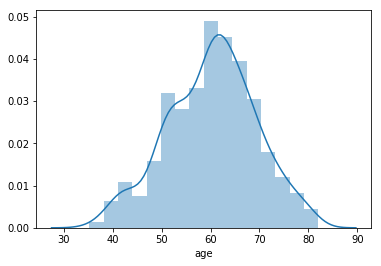

In [34]:
seaborn.distplot(train_set_labelled_c["age"])
plt.show()

In [35]:
train_set_c = train_set_labelled_c.append(train_set_unlabelled_c)

#### Age####

In [36]:
age_scaler = StandardScaler()
age_scaler.fit(train_set_c["age"].values.reshape(-1,1))
train_set_unlabelled_c["age"] = age_scaler.transform(train_set_unlabelled_c["age"].values.reshape(-1,1))
train_set_unlabelled_c["age"] = age_scaler.transform(train_set_unlabelled_c["age"].values.reshape(-1,1))
train_set_labelled_c["age"] = age_scaler.transform(train_set_labelled_c["age"].values.reshape(-1,1))
test_set_labelled_c["age"] = age_scaler.transform(test_set_labelled_c["age"].values.reshape(-1,1))
valid_set_labelled_c["age"] = age_scaler.transform(valid_set_labelled_c["age"].values.reshape(-1,1))

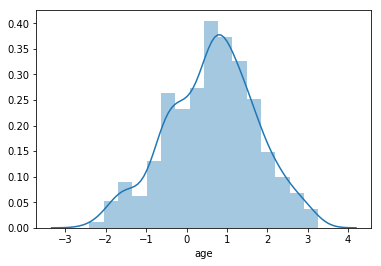

In [37]:
seaborn.distplot(train_set_labelled_c["age"])
plt.show()

#### Sex####

Let's one hot encode. At the moment 1 is Male, 2 is Female. We'll encode so that 1 is Male and 0 is Female.

In [38]:
def encode_sex(dataframe):
    sex_encoder = OneHotEncoder()
    sex_encoder.fit(train_set_c[["sex"]])
    
    dataframe["male"] = sex_encoder.transform(dataframe[["sex"]]).toarray()[:,0]
    dataframe.drop(["sex"],axis=1,inplace=True)
    return dataframe

First column is 1 if male. 

In [39]:
train_set_unlabelled_c = encode_sex(train_set_unlabelled_c)
train_set_labelled_c = encode_sex(train_set_labelled_c)
test_set_labelled_c = encode_sex(test_set_labelled_c)
valid_set_labelled_c = encode_sex(valid_set_labelled_c)

## Omic data ##

In [53]:
os.chdir(epic_italy_path)
epic_italy_betas = pd.read_csv('epic_italy_betas.csv', index_col=0)
epic_italy_betas = epic_italy_betas.transpose()
epic_italy_betas.reset_index(inplace=True)

In [54]:
os.chdir(cvd_path)
cvd_omics = pd.read_csv('epigenomic/preprocessed_betas.csv', index_col=0)
cvd_omics = cvd_omics.transpose()
cvd_omics.reset_index(inplace=True)

In [55]:
harmonised_path = '/local/scratch/rp542/data/harmonised_data'
os.chdir(harmonised_path)
harmonised_omics = pd.read_csv('harmonised_betas.csv', index_col=0)
harmonised_omics = harmonised_omics.transpose()
harmonised_omics.reset_index(inplace=True)

In [56]:
epic_italy_cvd_overlap = list(set(list(epic_italy_betas.columns)) & set(list(cvd_omics.columns)))
omic_columns = list(set(list(harmonised_omics.columns)) & set(epic_italy_cvd_overlap))

harmonised_omics = harmonised_omics[omic_columns]
cvd_omics = cvd_omics[omic_columns]
epic_italy_betas = epic_italy_betas[omic_columns]
omics = harmonised_omics.append(cvd_omics)
omics = omics.append(epic_italy_betas)

Not all the train_set_unlabelled_data have omics data. I'll just remove the ones who don't for below.

In [57]:
X_train_omics_unlabelled = omics[omics["index"].isin(train_set_unlabelled["index"])]
X_train_omics_labelled = omics[omics["index"].isin(train_set_labelled["index"])]
X_test_omics = omics[omics["index"].isin(test_set_labelled["index"])]
X_valid_omics = omics[omics["index"].isin(valid_set_labelled["index"])]

In [58]:
X_tv_cv1= omics[omics["index"].isin(tv_cv1["index"])]
X_tv_cv2= omics[omics["index"].isin(tv_cv2["index"])]
X_tv_cv3= omics[omics["index"].isin(tv_cv3["index"])]
X_tv_cv4= omics[omics["index"].isin(tv_cv4["index"])]
X_tv_cv5= omics[omics["index"].isin(tv_cv5["index"])]

X_tv_cv = pd.concat([X_tv_cv1,
                    X_tv_cv2,
                    X_tv_cv3,
                    X_tv_cv4,
                    X_tv_cv5])

print(X_tv_cv1.shape[0])
print(X_tv_cv2.shape[0])
print(X_tv_cv3.shape[0])
print(X_tv_cv4.shape[0])
print(X_tv_cv5.shape[0])


70
87
93
111
110


In [59]:
data = {"Fold":[1,2,3,4,5],
       "number_of_elements":[70,87,93,111,110]}

cv_indices = pd.DataFrame(data, columns = ['Fold','number_of_elements'])

### Interpolatation and scaling  ###

In [60]:
X_train_omics_all = X_train_omics_unlabelled.append(X_train_omics_labelled)
X_train_omics_all.reset_index(inplace=True)
X_train_omics_all.drop(["level_0"],axis=1,inplace=True)

X_index = X_train_omics_all["index"]
X_train = X_train_omics_all.drop(["index"],axis=1)

omics_scaler = StandardScaler()
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)

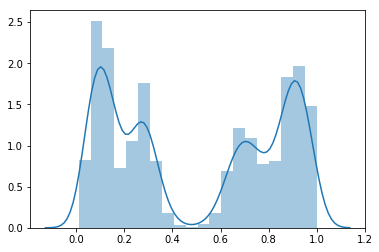

In [61]:
seaborn.distplot(X_train_imputed[:,13000:13010])
plt.show()

In [62]:
X_train_imputed = omics_scaler.fit_transform(X_train_imputed)


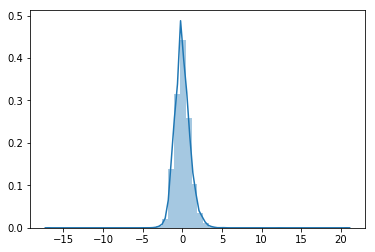

In [63]:
seaborn.distplot(X_train_imputed[:,12000:12010])
plt.show()

In [64]:
omics_scaler2 = MinMaxScaler()
X_train_imputed = omics_scaler2.fit_transform(X_train_imputed)


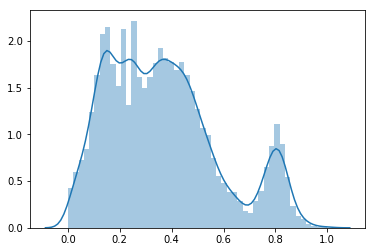

In [65]:
seaborn.distplot(X_train_imputed[:,12000:12010])
plt.show()

In [66]:
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

X_train_omics_all = X_train_imputed.join(X_index)

X_train_omics_unlabelled = X_train_omics_all[X_train_omics_all["index"].isin(train_set_unlabelled["index"])]

X_train_omics_labelled = X_train_omics_all[X_train_omics_all["index"].isin(train_set_labelled["index"])]

In [67]:
# for the cv 
X_tv_cv.reset_index(inplace=True)
X_tv_cv.drop(["level_0"],axis=1,inplace=True)


X_index = X_tv_cv["index"]
X_tv_cv = X_tv_cv.drop(["index"],axis=1)


omics_scaler = StandardScaler()
imputer = SimpleImputer(strategy="median")
X_tv_cv_imputed = imputer.fit_transform(X_tv_cv)
X_tv_cv_imputed = omics_scaler.fit_transform(X_tv_cv_imputed)
omics_scaler2 = MinMaxScaler()
X_tv_cv_imputed = omics_scaler2.fit_transform(X_tv_cv_imputed)

X_tv_cv_imputed = pd.DataFrame(X_tv_cv_imputed, columns=X_tv_cv.columns)

X_tv_cv = X_tv_cv_imputed.join(X_index)

In [68]:
X_test_omics.reset_index(inplace=True)
X_test_omics.drop(["level_0"],axis=1,inplace=True)

X_index = X_test_omics["index"]

X_test = X_test_omics.drop(["index"],axis=1)
X_test_imputed = imputer.transform(X_test)

/home/rp542/venv/lib/python3.5/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


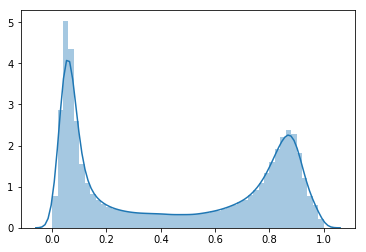

In [69]:
seaborn.distplot(X_test_imputed)
plt.show()

In [70]:
X_test_imputed = omics_scaler.transform(X_test_imputed)


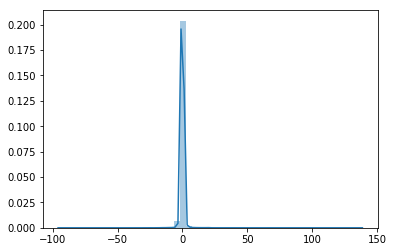

In [71]:
seaborn.distplot(X_test_imputed)
plt.show()

In [72]:
X_test_imputed = omics_scaler2.transform(X_test_imputed)


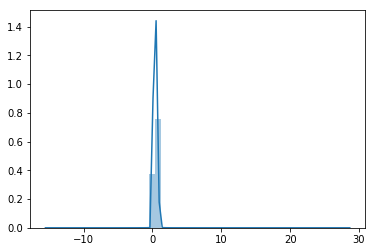

In [73]:
seaborn.distplot(X_test_imputed)
plt.show()

In [74]:
X_test_imputed[np.where(X_test_imputed < 0)] = 0

X_test_imputed[np.where(X_test_imputed > 1)] = 1

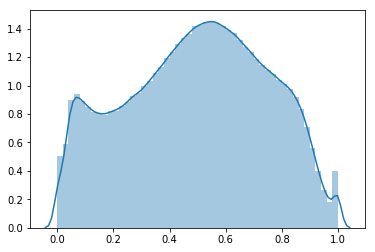

In [75]:
seaborn.distplot(X_test_imputed)
plt.show()

Let's set any values above 1 equal to 1, and any values below 0 equal to 0

In [76]:
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

X_test_omics = X_test_imputed.join(X_index)

In [77]:
X_valid_omics = X_valid_omics.reset_index()
X_valid_omics = X_valid_omics.drop(["level_0"],axis=1)

X_index = X_valid_omics["index"]

X_valid = X_valid_omics.drop(["index"],axis=1)
X_valid_imputed = imputer.transform(X_valid)


X_valid_imputed = omics_scaler.transform(X_valid_imputed)
X_valid_imputed = omics_scaler2.transform(X_valid_imputed)
X_valid_imputed[np.where(X_valid_imputed < 0)] = 0
X_valid_imputed[np.where(X_valid_imputed > 1)] = 1

X_valid_imputed = pd.DataFrame(X_valid_imputed, columns=X_valid.columns)

X_valid_omics = X_valid_imputed.join(X_index)

Look at the difference between number of test set samples and numbers with omic data

In [78]:
test_set_labelled.shape

(165, 22)

In [79]:
X_test_omics.shape

(106, 16591)

Now we only select rows which have omic data.

### Tidying up ###

In [80]:
train_set_labelled_c = train_set_labelled_c[train_set_labelled_c["index"].isin(X_train_omics_labelled["index"])]
train_set_unlabelled_c = train_set_unlabelled_c[train_set_unlabelled_c["index"].isin(X_train_omics_unlabelled["index"])]
test_set_labelled_c = test_set_labelled_c[test_set_labelled_c["index"].isin(X_test_omics["index"])]
valid_set_labelled_c = valid_set_labelled_c[valid_set_labelled_c["index"].isin(X_valid_omics["index"])]

train_set_labelled_y = train_set_labelled_y[train_set_labelled_y["index"].isin(X_train_omics_labelled["index"])]
test_set_labelled_y = test_set_labelled_y[test_set_labelled_y["index"].isin(X_test_omics["index"])]
valid_set_labelled_y = valid_set_labelled_y[valid_set_labelled_y["index"].isin(X_valid_omics["index"])]


In [81]:
tv_cv_y1 = tv_cv_y1[tv_cv_y1["index"].isin(X_tv_cv1["index"])]
tv_cv_y2 = tv_cv_y2[tv_cv_y2["index"].isin(X_tv_cv2["index"])]
tv_cv_y3 = tv_cv_y3[tv_cv_y3["index"].isin(X_tv_cv3["index"])]
tv_cv_y4 = tv_cv_y4[tv_cv_y4["index"].isin(X_tv_cv4["index"])]
tv_cv_y5 = tv_cv_y5[tv_cv_y5["index"].isin(X_tv_cv5["index"])]


In [82]:
#sort by index and then drop it
X_train_omics_unlabelled = X_train_omics_unlabelled.sort_values(["index"]).drop(["index"],axis=1)
X_train_omics_labelled = X_train_omics_labelled.sort_values(["index"]).drop(["index"],axis=1)
X_test_omics = X_test_omics.sort_values(["index"]).drop(["index"],axis=1)
X_valid_omics = X_valid_omics.sort_values(["index"]).drop(["index"],axis=1)
train_set_labelled_c = train_set_labelled_c.sort_values(["index"]).drop(["index"],axis=1)
train_set_unlabelled_c = train_set_unlabelled_c.sort_values(["index"]).drop(["index"],axis=1)
test_set_labelled_c = test_set_labelled_c.sort_values(["index"]).drop(["index"],axis=1)
valid_set_labelled_c = valid_set_labelled_c.sort_values(["index"]).drop(["index"],axis=1)
train_set_labelled_y = train_set_labelled_y.sort_values(["index"]).drop(["index"],axis=1)
test_set_labelled_y = test_set_labelled_y.sort_values(["index"]).drop(["index"],axis=1)
valid_set_labelled_y = valid_set_labelled_y.sort_values(["index"]).drop(["index"],axis=1)


#reset indices in dataframes
X_train_omics_unlabelled = X_train_omics_unlabelled.reset_index().drop(["index"],axis=1)
X_train_omics_labelled = X_train_omics_labelled.reset_index().drop(["index"],axis=1)
X_test_omics = X_test_omics.reset_index().drop(["index"],axis=1)
X_valid_omics = X_valid_omics.reset_index().drop(["index"],axis=1)
train_set_labelled_c = train_set_labelled_c.reset_index().drop(["index"],axis=1)
train_set_unlabelled_c = train_set_unlabelled_c.reset_index().drop(["index"],axis=1)
test_set_labelled_c = test_set_labelled_c.reset_index().drop(["index"],axis=1)
valid_set_labelled_c = valid_set_labelled_c.reset_index().drop(["index"],axis=1)
train_set_labelled_y = train_set_labelled_y.reset_index().drop(["index"],axis=1)
test_set_labelled_y = test_set_labelled_y.reset_index().drop(["index"],axis=1)
valid_set_labelled_y = valid_set_labelled_y.reset_index().drop(["index"],axis=1)

#scaling
y_scaler = StandardScaler()
train_set_labelled_y = pd.DataFrame(y_scaler.fit_transform(train_set_labelled_y),columns=train_set_labelled_y.columns)
test_set_labelled_y = pd.DataFrame(y_scaler.transform(test_set_labelled_y),columns=test_set_labelled_y.columns)
valid_set_labelled_y = pd.DataFrame(y_scaler.transform(valid_set_labelled_y),columns=valid_set_labelled_y.columns)


In [83]:
X_tv_cv1= X_tv_cv[X_tv_cv["index"].isin(tv_cv1["index"])]
X_tv_cv2= X_tv_cv[X_tv_cv["index"].isin(tv_cv2["index"])]
X_tv_cv3= X_tv_cv[X_tv_cv["index"].isin(tv_cv3["index"])]
X_tv_cv4= X_tv_cv[X_tv_cv["index"].isin(tv_cv4["index"])]
X_tv_cv5= X_tv_cv[X_tv_cv["index"].isin(tv_cv5["index"])]

#sort by index and then drop it
X_tv_cv1 = X_tv_cv1.sort_values(["index"]).drop(["index"],axis=1)
X_tv_cv2 = X_tv_cv2.sort_values(["index"]).drop(["index"],axis=1)
X_tv_cv3 = X_tv_cv3.sort_values(["index"]).drop(["index"],axis=1)
X_tv_cv4 = X_tv_cv4.sort_values(["index"]).drop(["index"],axis=1)
X_tv_cv5 = X_tv_cv5.sort_values(["index"]).drop(["index"],axis=1)

X_tv_cv = pd.concat([X_tv_cv1,
                    X_tv_cv2,
                    X_tv_cv3,
                    X_tv_cv4,
                    X_tv_cv5])

tv_cv_y1= tv_cv_y1.sort_values(["index"]).drop(["index"],axis=1)
tv_cv_y2= tv_cv_y2.sort_values(["index"]).drop(["index"],axis=1)
tv_cv_y3= tv_cv_y3.sort_values(["index"]).drop(["index"],axis=1)
tv_cv_y4= tv_cv_y4.sort_values(["index"]).drop(["index"],axis=1)
tv_cv_y5= tv_cv_y5.sort_values(["index"]).drop(["index"],axis=1)


tv_cv_y = pd.concat([tv_cv_y1,
                    tv_cv_y2,
                    tv_cv_y3,
                    tv_cv_y4,
                    tv_cv_y5])

#reset indices in dataframes
tv_cv_y = tv_cv_y.reset_index().drop(["index"],axis=1)
X_tv_cv = X_tv_cv.reset_index().drop(["index"],axis=1)

#scaling
y_scaler = StandardScaler()
tv_cv_y = pd.DataFrame(y_scaler.fit_transform(tv_cv_y),columns=tv_cv_y.columns)

## Save data into numpy frames ##

In [84]:
save_path = 'save_path'
os.chdir(save_path)

In [85]:
X_train_omics_unlabelled.to_csv("X_train_omics_unlabelled.csv")
X_train_omics_labelled.to_csv("X_train_omics_labelled.csv")
X_test_omics.to_csv("X_test_omics.csv")
X_valid_omics.to_csv("X_valid_omics.csv")
train_set_labelled_c.to_csv("train_set_labelled_c.csv")
train_set_unlabelled_c.to_csv("train_set_unlabelled_c.csv")
test_set_labelled_c.to_csv("test_set_labelled_c.csv")
valid_set_labelled_c.to_csv("valid_set_labelled_c.csv")
train_set_labelled_y.to_csv("train_set_labelled_y.csv")
test_set_labelled_y.to_csv("test_set_labelled_y.csv")
valid_set_labelled_y.to_csv("valid_set_labelled_y.csv")

In [86]:
save_path2 = 'save_path2'
os.chdir(save_path2)

In [87]:
tv_cv_y.to_csv("tv_cv_y.csv")
X_tv_cv.to_csv("X_tv_cv.csv")

cv_indices.to_csv("cv_indices.csv")